In [1]:
import networkx as nx
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

plt.rcParams['figure.dpi'] = 200

# Livestock T2T rDNA graph overlay analysis
---

**Objective**: Attempt to identify and resolve two sets of graphs constructed from rDNA reads and the whole genome, respectively. 

My hope is that by overlaying the graphs and creating edges that correspond to the counts of reads that are shared between the whole genome and rDNA subgraphs, the separation of rDNA subgraphs will be easier to manage. 

I need to create the infrastructure for loading the GFA files and then create the edges between them. I will try to use different symbols for each node to start, so that I can distinguish between the assembly and sub-assembly graph nodes.

In [2]:
from collections import defaultdict

class graphOverlay:
    
    def __init__(self):
        self.graph = nx.Graph()
        self.subgraphNodes = defaultdict(list)
        self.nodeToSubgraph = dict()
        self.symbolToNodes = defaultdict(list)
        self.nodeEdgeList = defaultdict(list)
        self.colorsToEdges = defaultdict(list)
        
    def readGFA(self, file, nodeSymbol, nodeSuffix, nodeCol, edgeCol):
        with open(file, 'r') as input:
            for l in input:
                s = l.rstrip().split()
                nLen = 0
                nodeName=s[1]
                
                # Handling node information
                if s[0] == 'S':
                    if s[2] == '*':
                        lntokens = s[3].split(':')
                        nLen = int(lntokens[2])
                    else:
                        nLen = len(s[2])
                    
                    self.graph.add_node(nodeName, length=nLen, color=nodeCol, symbol=nodeSymbol, asm=nodeSuffix)
                    
                    self.subgraphNodes[nodeSuffix].append(nodeName)
                    self.nodeToSubgraph[nodeName] = nodeSuffix
                    
                # Handling edge construction
                if s[0] == 'L':
                    # Setting default weight at a uniform 40. May need to revise later
                    self.graph.add_edge(s[1], s[3], color=edgeCol, weight=40)
                    self.nodeEdgeList[s[1]].append((s[1], s[3]))
                    self.nodeEdgeList[s[3]].append((s[1], s[3]))
                
                        
                    
    def updateNodeAttributes(self, nodeList, nodeSuffix, nodeSymbol, nodeColor):
        nodeDict = dict()
        for n in nodeList:
            nodeName = n
            self.graph.nodes[nodeName]['color'] = nodeColor
            self.graph.nodes[nodeName]['symbol'] = nodeSymbol
        self._updateNodeSymbols()
            
    def _updateNodeSymbols(self):
        self.symbolToNodes = defaultdict(list)
        nSymb = nx.get_node_attributes(self.graph, 'symbol')
        for n in self.graph.nodes:
            self.symbolToNodes[nSymb[n]].append(n)
    
    def _updateEdgeColors(self):
        self.colorsToEdges = defaultdict(list)
        eColors = nx.get_edge_attributes(self.graph, 'color')
        for e in self.graph.edges:
            self.colorsToEdges[eColors[e]].append(e)
        
    def prune(self):
        # this is to remove all single nodes without any edges in the subgraph
        self.graph.remove_nodes_from(list(nx.isolates(self.graph)))
        
        self._updateNodeSymbols()
        self._updateEdgeColors()
    
    def findInterGraphEdges(self, nset, nsymbol):
        # This function returns a set of nodes and list of edges from the alternative symbol that should be connected together
        nSymb = nx.get_node_attributes(self.graph, 'symbol')
        altNodes = set()
        validEdges = list()
        for n in nset:
            for l in self.nodeEdgeList[n]:
                for i in l:
                    found = False

                    if nSymb[i] != nsymbol:
                        altNodes.add(i)
                        found = True
                    if found:
                        validEdges.append(l)
        return altNodes, validEdges
    
    def selectivePrune(self, nlist):
        # This is a backup in case I need to remove nodes manually
        self.graph.remove_nodes_from(nlist)
        for n in nlist:
            for f, r in self.nodeEdgeList[n]:
                self.graph.remove_edge(f, r)
        
    def addNewEdges(self, file, fassemblyPre, sassemblyPre, edgeCol):
        # This is a specialized function designed to read a link file specifically for this analysis
        edges = defaultdict(int)
        with open(file, 'r') as input:
            for l in input:
                s = l.rstrip().split()
                key = f'{s[1]};{s[2]}'
                edges[key] += 1
                
        for k, v in edges.items():
            s = k.split(';')
            self.graph.add_edge(s[0], s[1], color=edgeCol, weight=v)
            self.nodeEdgeList[s[0]].append((s[0], s[1]))
            self.nodeEdgeList[s[1]].append((s[0], s[1]))

#### All vs all analysis
---
OK, I've created the precursor class with helper functions, so I should be able to create objects I need to move forward. Let's try to create the graph with all nodes and then sort things out from there. I am likely going to need to crop things down substantially, but it'll be good to test things out with the full dataset first.

In [3]:
subgraphFile = "C:/SharedFolders/sequencing_projects/livestock_t2t/rrna_nodefilter_array/sheep_rdna_2501_250_graph.gfa"
assemblyGraphFile = "C:/SharedFolders/sequencing_projects/livestock_t2t/unitig-popped-unitig-normal-connected-tip.noseq.gfa"
overlayEdgeFile = "C:/SharedFolders/sequencing_projects/livestock_t2t/rrna_nodefilter_array/sheep_rdna_2501_250.allassoc.tab"
specialNodeFile = "C:/SharedFolders/sequencing_projects/livestock_t2t/rrna_nodefilter_array/candidate_rdna_unitigs.list"

specialNodeList = list()
with open(specialNodeFile, 'r') as input:
    for l in input:
        l = l.rstrip()
        specialNodeList.append(l)

# Colors and other graph attributes
subAsmPre = 'S'
primAsmPre = 'P'
subAsmCol = 'b'
primAsmCol = 'w'
specAsmCol = 'r'
primAsmEdgeCol = 'k'
subAsmEdgeCol = 'b'
newEdgeCol = 'c'

# Nodesymbols
primAsmSym = 's'
subAsmSym = 'o'

# Setup the graph object
worker = graphOverlay()

worker.readGFA(subgraphFile, subAsmSym, subAsmPre, subAsmCol, subAsmEdgeCol)

worker.prune()

worker.readGFA(assemblyGraphFile, primAsmSym, primAsmPre, primAsmCol, primAsmEdgeCol)

worker.updateNodeAttributes(specialNodeList, primAsmPre, primAsmSym, specAsmCol)

# now to add the new edges
worker.addNewEdges(overlayEdgeFile, subAsmPre, primAsmPre, newEdgeCol)

OK, this will be a test of the default layout to see how everything is arranged. I expect this to be a total mess.

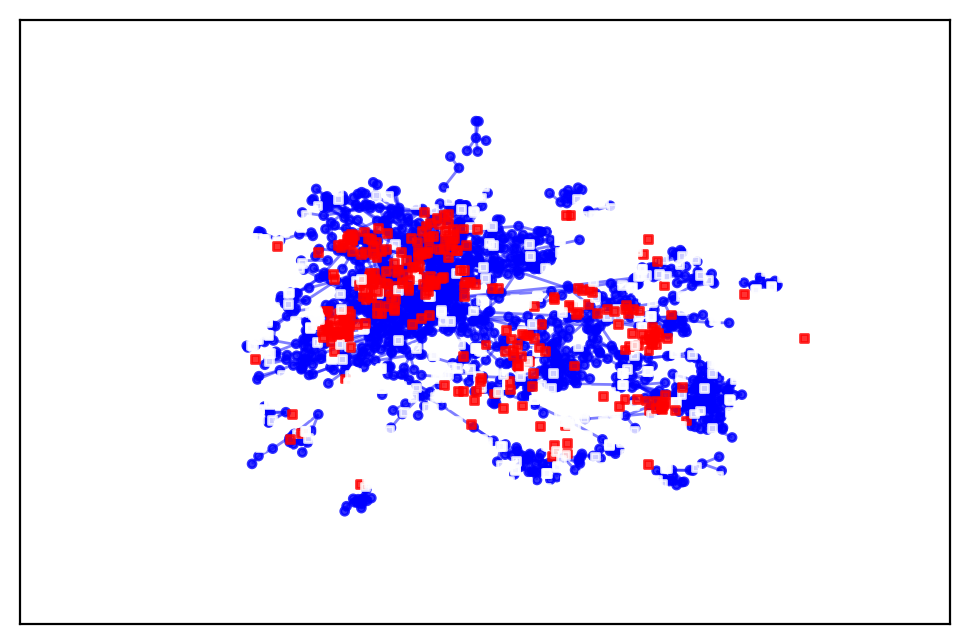

In [4]:
gobj = worker.graph

pos = nx.spring_layout(gobj, k=0.11)

nColors = nx.get_node_attributes(gobj, 'color')
eColors = nx.get_edge_attributes(gobj, 'color')

for k, nodes in worker.symbolToNodes.items():
    nx.draw_networkx_nodes(gobj, pos, nodelist=nodes, node_color=[nColors[n] for n in nodes], 
                       node_size = 8, node_shape=k, alpha=0.8)
    
for k, edges in worker.colorsToEdges.items():
    nx.draw_networkx_edges(gobj, pos, edgelist=edges, width=1, alpha=0.5, edge_color=k)

## K=2501 and establishing the helper functions
---

OK, now that I have the framework, I need to tease apart individual subgraphs from the main graph and plot them individually or tally intersections separately. I think that I can do this by creating separate networks for the rDNA arrays, then pulling only those nodes and the nodes that have edges between them in the main graph. That should be more readable than the current alternative. 

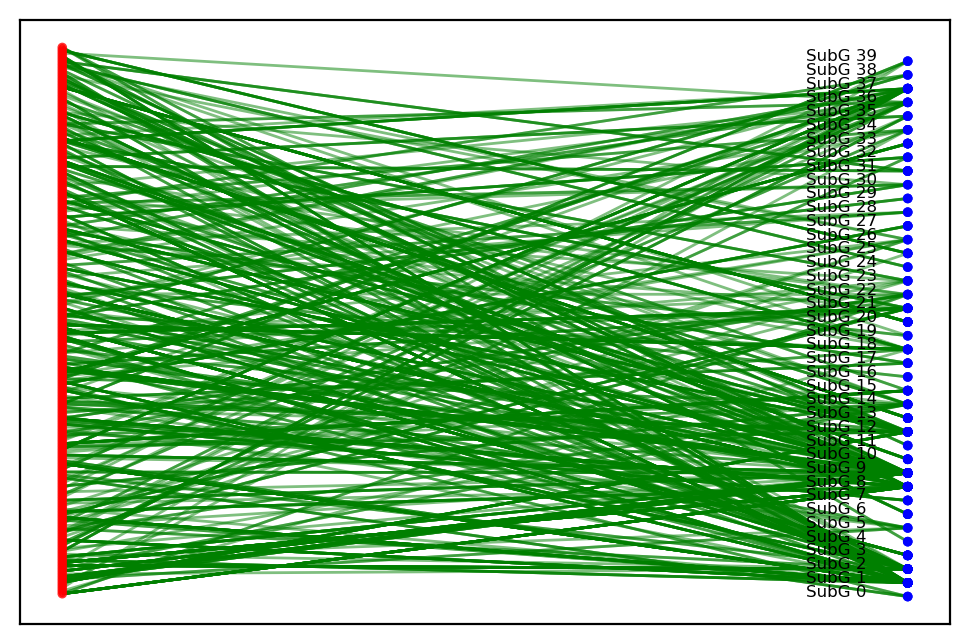

In [25]:
# Here is another helper function to print a bigraph for each subset graph
# This will also allow me to remove specific clusters for better visualization
def printSubsetBigraph(subgraphFile, subAsmSym, subAsmPre, subAsmCol, subAsmEdgeCol, 
                       worker, removal=set(), asmNodeText=False, asmNodeCluster=False):
    subset = graphOverlay()
    subset.readGFA(subgraphFile, subAsmSym, subAsmPre, subAsmCol, subAsmEdgeCol)
    subset.prune()

    fullnodes = set(subset.graph.nodes)
    subsetGraphs = nx.connected_components(subset.graph)
    subsetList = list(subsetGraphs)
    subGNodes = defaultdict(list)
    subGCoords = dict()
    for i, subg in enumerate(subsetList):
        subGNodes[i].extend([n for n in subg])    
        
    totNodes = fullnodes
    
    # remove node groups if we decide to filter specific subgroups
    if len(removal) > 0:
        totNodes = totNodes.difference(removal)
    
    # I am directly filtering the previous graph with the total set of subgraph nodes to find all valid edges
    (asmNodeSet, asmValidEdges) = worker.findInterGraphEdges(totNodes, subAsmSym)
    
    pos = {node:[0.25, i + 1] for i,node in enumerate(asmNodeSet)}
    asmNodeGroups = defaultdict(list)
    separator = 1
    if asmNodeCluster:
        asmSubGraph = worker.graph.subgraph(asmNodeSet)
        for i, subg in enumerate(nx.connected_components(asmSubGraph)):
            pos.update({node:[0.25, i + 1] for node in subg})
            asmNodeGroups[i].extend([n for n in subg])
    else:
        separator = len(asmNodeSet) / len(subsetList)
            
    for i, subg in enumerate(subsetList):
        pos.update({node:[0.75, i * separator] for node in subg})
        subGCoords[i] = i * separator
    
    

    totNodes = list(totNodes.union(asmNodeSet))
    fig, axe = plt.subplots()

    nColors = nx.get_node_attributes(worker.graph, 'color')
    nx.draw_networkx_nodes(worker.graph, pos, ax = axe, nodelist=list(totNodes), 
                           node_color=[nColors[n] for n in list(totNodes)], 
                           node_size = 6, node_shape='o', alpha=0.8)

    eWeights = nx.get_edge_attributes(worker.graph, 'weight')
    nx.draw_networkx_edges(worker.graph, pos, ax = axe, edgelist=asmValidEdges, width=1,
                           alpha = 0.5, edge_color='g')

    for i in subGCoords.keys():
        axe.text(0.69, subGCoords[i], f'SubG {i}', fontsize=6)
    if asmNodeText:
        if asmNodeCluster:
            for i in range(len(asmNodeGroups.keys())):
                group = asmNodeGroups[i]
                axe.text(0.25, i + 1, f'ASMG {i} nContigs: {len(group)}', fontsize=4)
        else:
            nLens = nx.get_node_attributes(worker.graph, 'length')
            for i, node in enumerate(asmNodeSet):
                axe.text(0.25, i + 1, f'ASM: {node} ln: {nLens.get(node, 0)}', fontsize=4)
        
    return subGNodes, asmNodeSet

subGNodes, asmNodeSet = printSubsetBigraph(subgraphFile, subAsmSym, subAsmPre, subAsmCol, subAsmEdgeCol, worker)

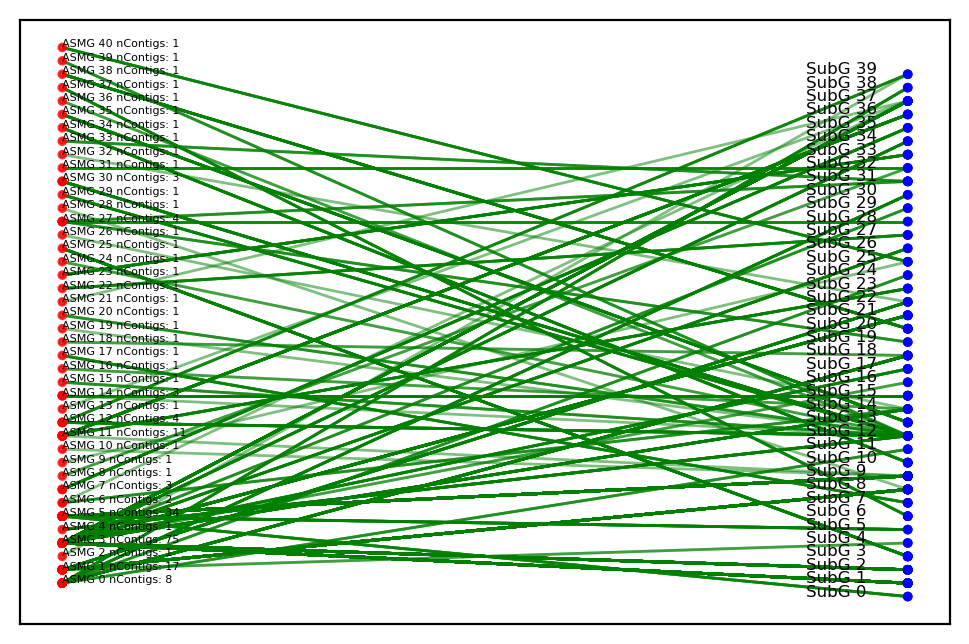

In [27]:
# Separating ASM nodes by clustering

subGNodes, asmNodeSet = printSubsetBigraph(subgraphFile, subAsmSym, subAsmPre, subAsmCol, subAsmEdgeCol, worker, [], True, True)

2: 1063
4: 51
11: 56


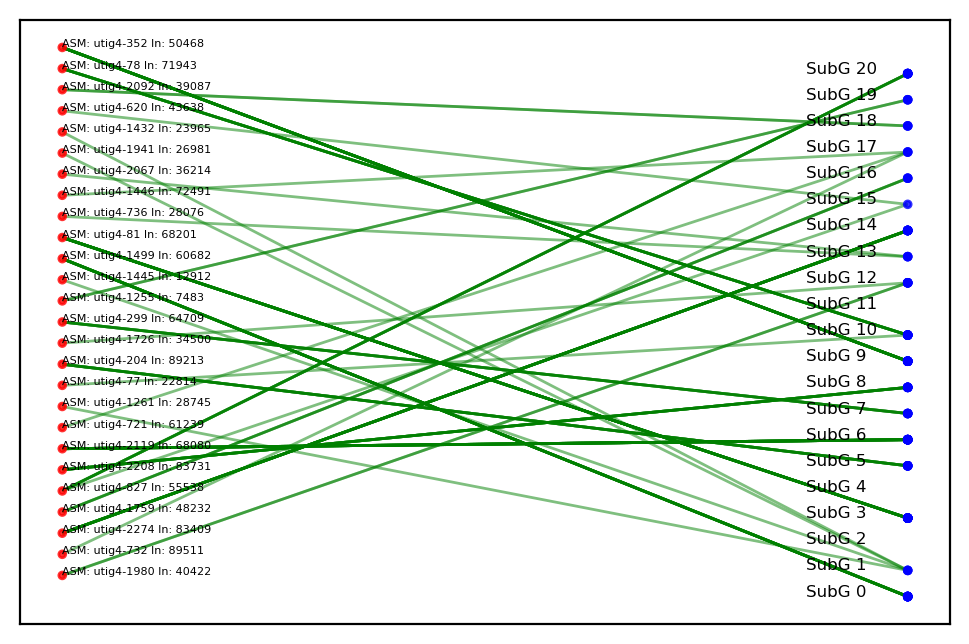

In [6]:
# Now testing this with the removal of subgraph 2, 4 and 11
removal = list()
for i in [2, 4, 11]:
    print(f'{i}: {len(subGNodes[i])}')
    removal.extend(subGNodes[i])
    
subGNodes, asmNodeSet = printSubsetBigraph(subgraphFile, subAsmSym, subAsmPre, subAsmCol, subAsmEdgeCol, worker, set(removal), True)

#### Take-away
---
OK, I'm on the right path to start automating this and interrogating the potential chromosome-level associations of these subgraphs. The problem is that it's hard to visualize each. So let's define a function to create subplots to plot each individual array for comparison.

The tandem bi-graph, subsets of rDNA array and even a histogram of residual ASM node lengths would be a great visualization tool. If I can collect several plots for each k value, then I can make a better informed decision on each.

In [7]:
def plotSubsetGraphs(subgraphFile, subAsmSym, subAsmPre, subAsmCol, subAsmEdgeCol, numRows, numCols):
    subset = graphOverlay()
    subset.readGFA(subgraphFile, subAsmSym, subAsmPre, subAsmCol, subAsmEdgeCol)
    subset.prune()

    fullnodes = set(subset.graph.nodes)
    subsetGraphs = nx.connected_components(subset.graph)
    
    
    fig, axs = plt.subplots(numRows, numCols)
    axsList = list(axs.flat)
    for i, subg in enumerate(subsetGraphs):
        subGraph = subset.graph.subgraph(subg)
        pos = nx.spring_layout(subg, k=0.11)
        axsList[i].axes.xaxis.set_visible(False)
        axsList[i].axes.yaxis.set_visible(False)
        axsList[i].set_title(f'SubG {i}', fontsize=6)
        nx.draw(subGraph, pos=pos, ax=axsList[i], node_size = 6, node_shape='o', alpha=0.8, node_color='b', font_size=6)
        
def asmGraphSubsetPlot(worker, asmNodes):
    subGraph = worker.graph.subgraph(asmNodes)
    nLengths = nx.get_node_attributes(subGraph, 'length')
    
    df = pd.DataFrame({'Contigs': [n for n in nLengths.keys()], 'Lengths' : [nLengths[n] for n in nLengths.keys()]})
    df = df.sort_values(by=['Lengths'], ascending=False)
    fig, axs = plt.subplots(2)
    
    pos = nx.spring_layout(subGraph, k=2)
    nx.draw(subGraph, pos=pos, ax=axs[0], node_size = 6, node_shape='o', alpha=0.8, 
            node_color='b', font_size=4, labels = {n : n for n in subGraph.nodes})
    
    df.plot.bar(x='Contigs', y='Lengths', ax=axs[1])

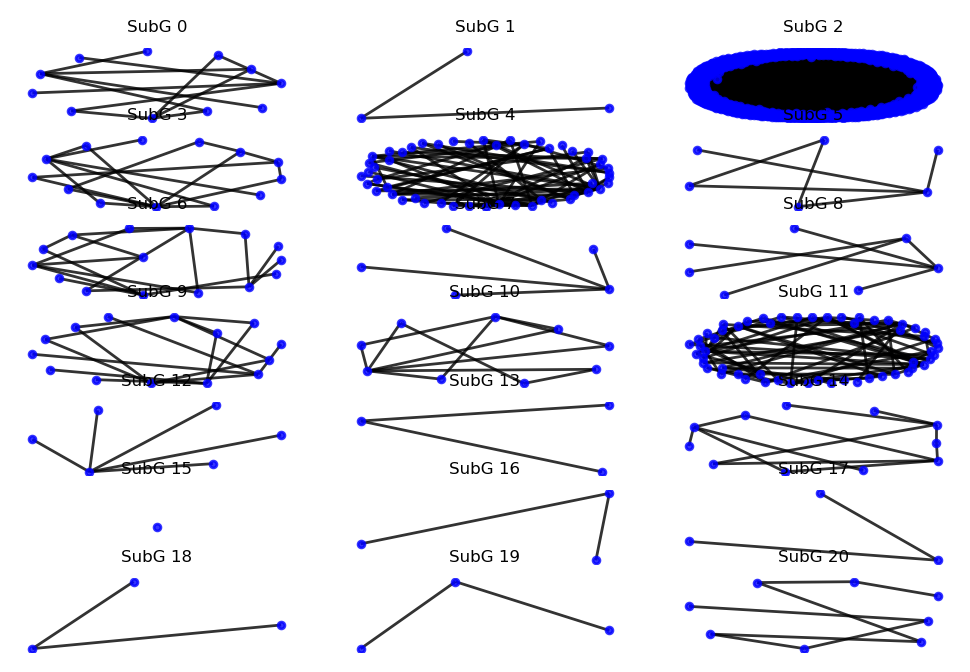

In [8]:
plotSubsetGraphs(subgraphFile, subAsmSym, subAsmPre, subAsmCol, subAsmEdgeCol, 7, 3)

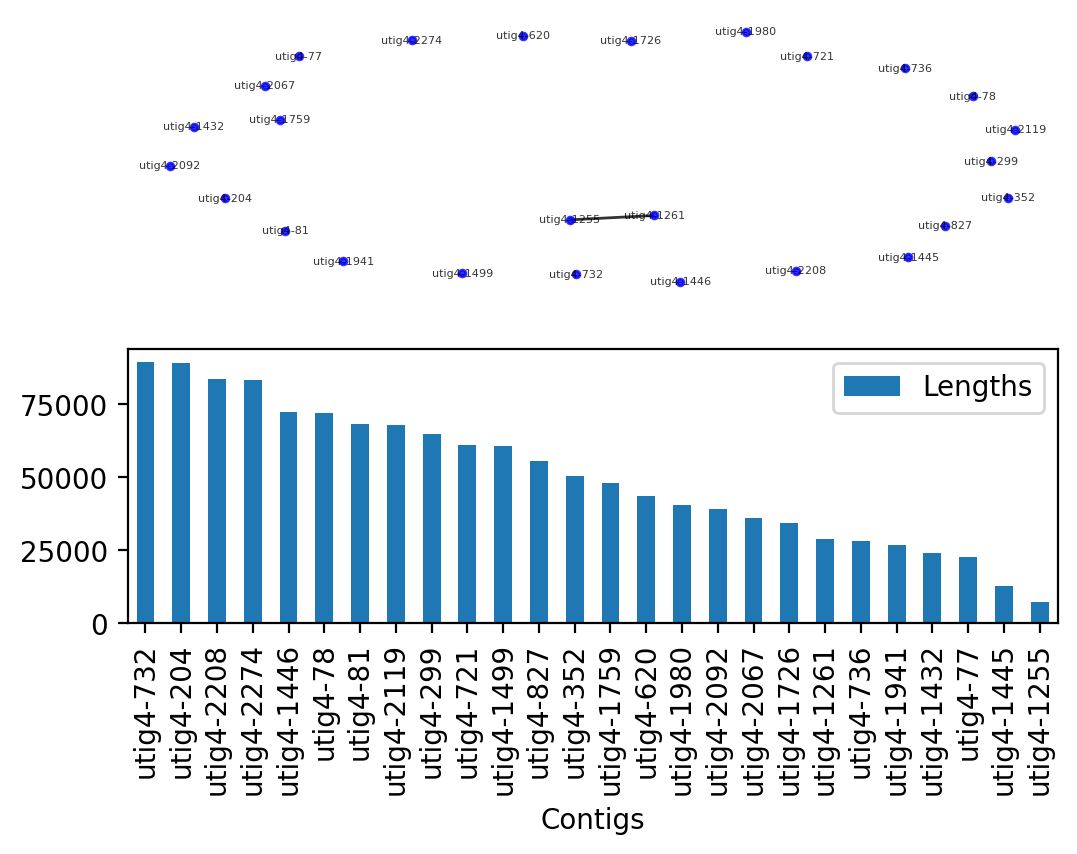

In [9]:
asmGraphSubsetPlot(worker, asmNodeSet)

## K=3501
---

OK, the next step up! Let's see if we can draw the next K value and find better connections between nodes, fewer multi-branched groups and cleaner associations with the main assembly.

#### First, the main node layout

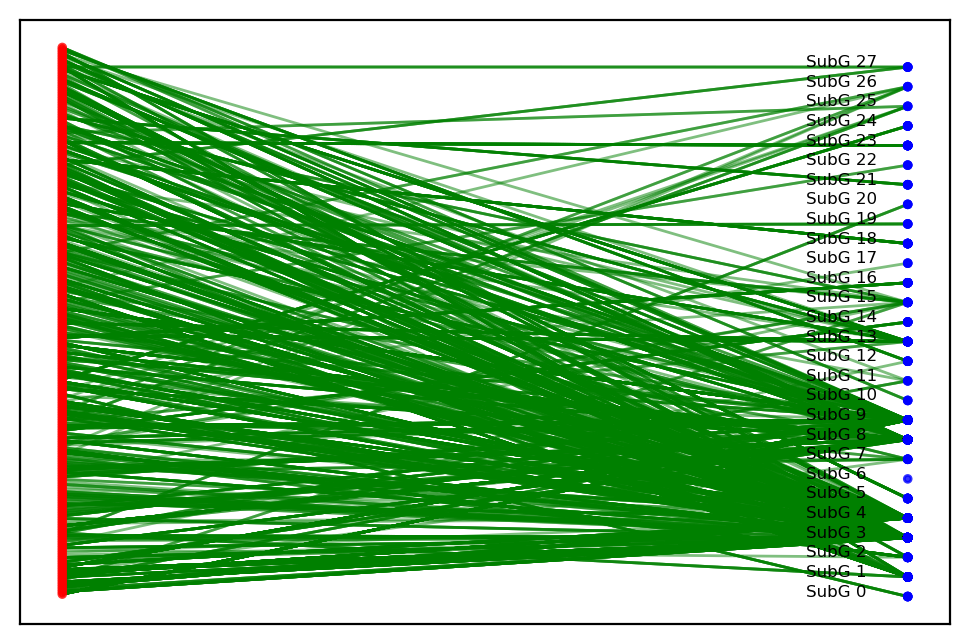

In [33]:
subgraphFile = "C:/SharedFolders/sequencing_projects/livestock_t2t/rrna_nodefilter_array/sheep_rdna_3501_350_graph.gfa"
overlayEdgeFile = "C:/SharedFolders/sequencing_projects/livestock_t2t/rrna_nodefilter_array/sheep_rdna_3501_350.allassoc.tab"

def setupWorker(subgraphFile, subAsmSym, subAsmPre, subAsmCol, subAsmEdgeCol, 
                assemblyGraphFile, primAsmSym, primAsmPre, primAsmCol, primAsmEdgeCol, 
                specialNodeList, specAsmCol, overlayEdgeFile, newEdgeCol):
    worker = graphOverlay()

    worker.readGFA(subgraphFile, subAsmSym, subAsmPre, subAsmCol, subAsmEdgeCol)

    worker.prune()

    worker.readGFA(assemblyGraphFile, primAsmSym, primAsmPre, primAsmCol, primAsmEdgeCol)

    worker.updateNodeAttributes(specialNodeList, primAsmPre, primAsmSym, specAsmCol)

    # now to add the new edges
    worker.addNewEdges(overlayEdgeFile, subAsmPre, primAsmPre, newEdgeCol)
    
    return worker

worker = setupWorker(subgraphFile, subAsmSym, subAsmPre, subAsmCol, subAsmEdgeCol, 
                assemblyGraphFile, primAsmSym, primAsmPre, primAsmCol, primAsmEdgeCol, 
                specialNodeList, specAsmCol, overlayEdgeFile, newEdgeCol)

subGNodes, asmNodeSet = printSubsetBigraph(subgraphFile, subAsmSym, subAsmPre, subAsmCol, subAsmEdgeCol, worker)

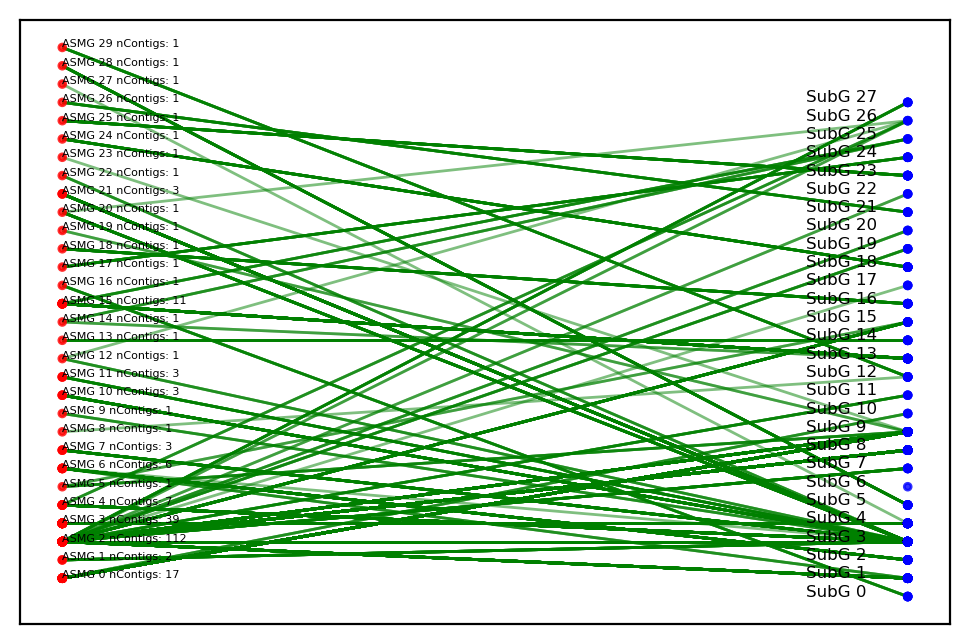

In [34]:
subGNodes, asmNodeSet = printSubsetBigraph(subgraphFile, subAsmSym, subAsmPre, subAsmCol, subAsmEdgeCol, worker, [], True, True)

3: 273
4: 100
8: 93
9: 116


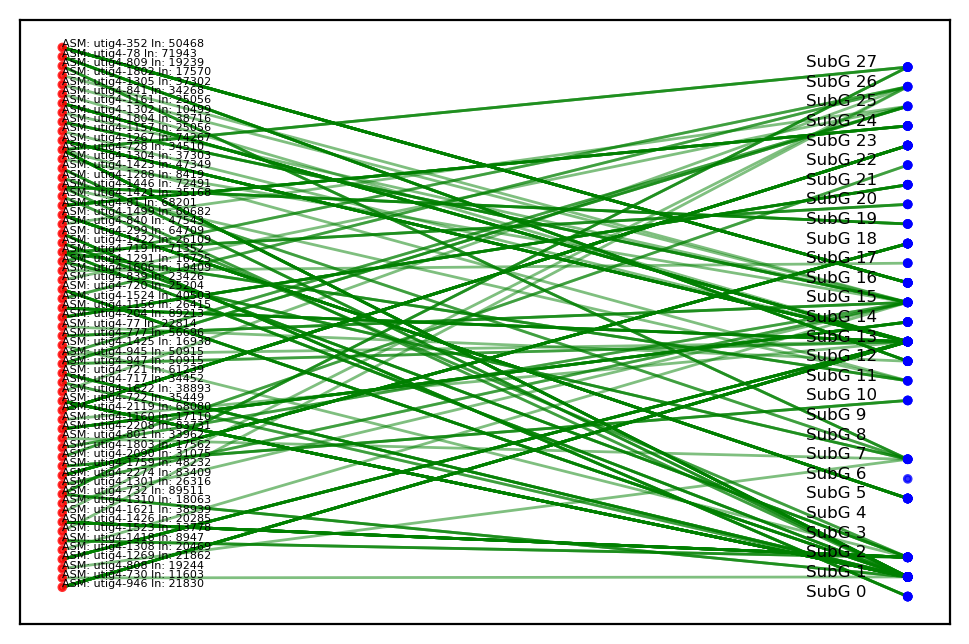

In [35]:
# Now testing this with the removal of subgraph 3, 4, 8 and 9
removal = list()
for i in [3, 4, 8, 9]:
    print(f'{i}: {len(subGNodes[i])}')
    removal.extend(subGNodes[i])
    
subGNodes, asmNodeSet = printSubsetBigraph(subgraphFile, subAsmSym, subAsmPre, subAsmCol, subAsmEdgeCol, worker, set(removal), True)

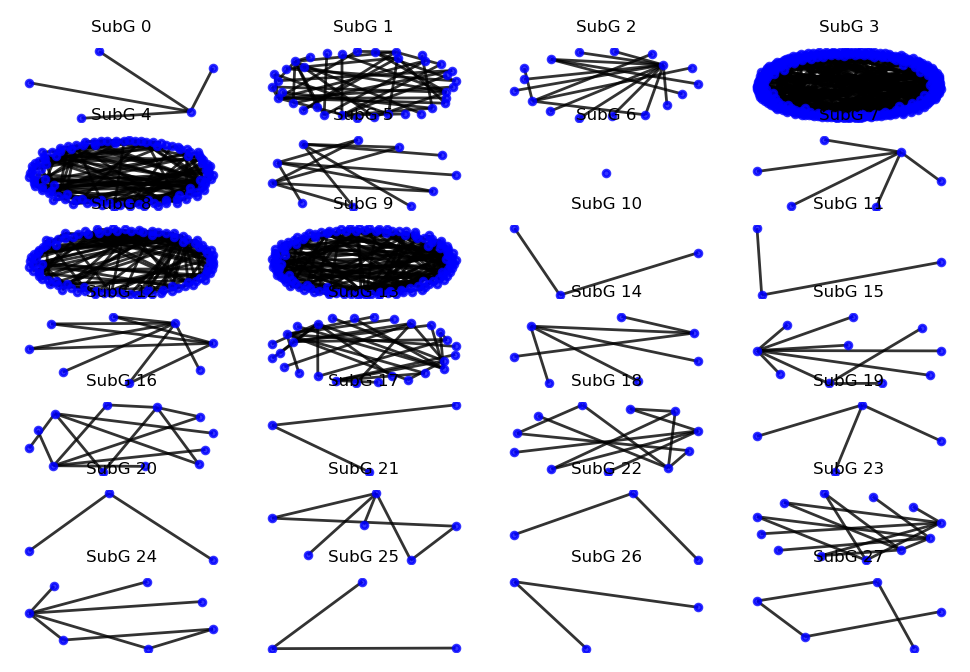

In [12]:
plotSubsetGraphs(subgraphFile, subAsmSym, subAsmPre, subAsmCol, subAsmEdgeCol, 7, 4)

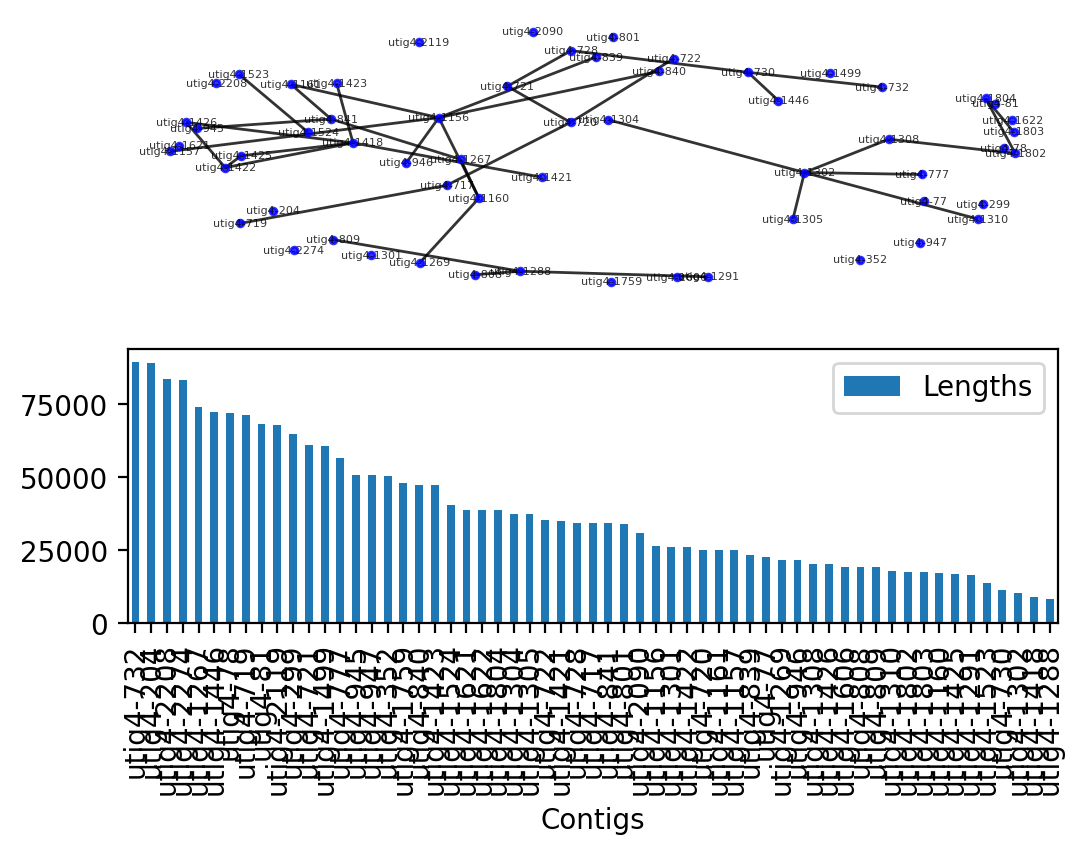

In [13]:
asmGraphSubsetPlot(worker, asmNodeSet)

#### The take-away
---
OK, this time we actually found associations of our arrays to one of the larger subgraphs of rDNA nodes in the assembly! This is a good incremental step, but we need to figure out how to tease this apart into subgraphs that span separate chromosomes. 

Let's try one last attempt to find associations by ONLY taking the subgraphs that correspond to 3,4, 8 and 9 in this run:

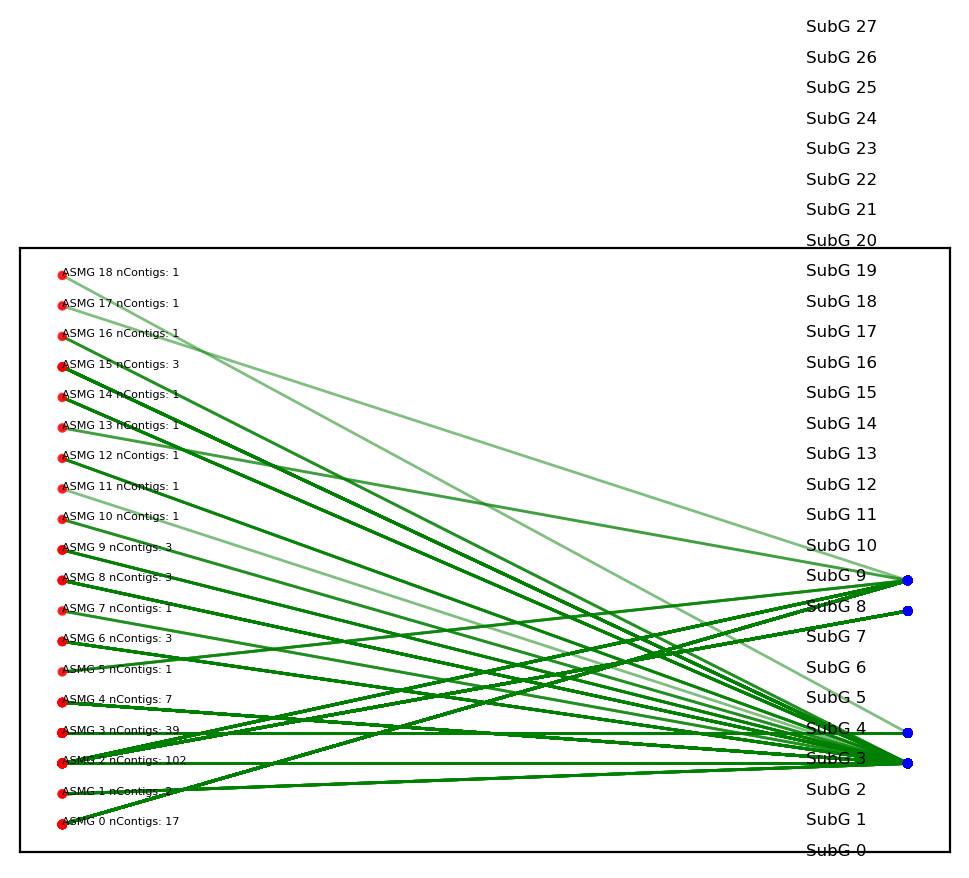

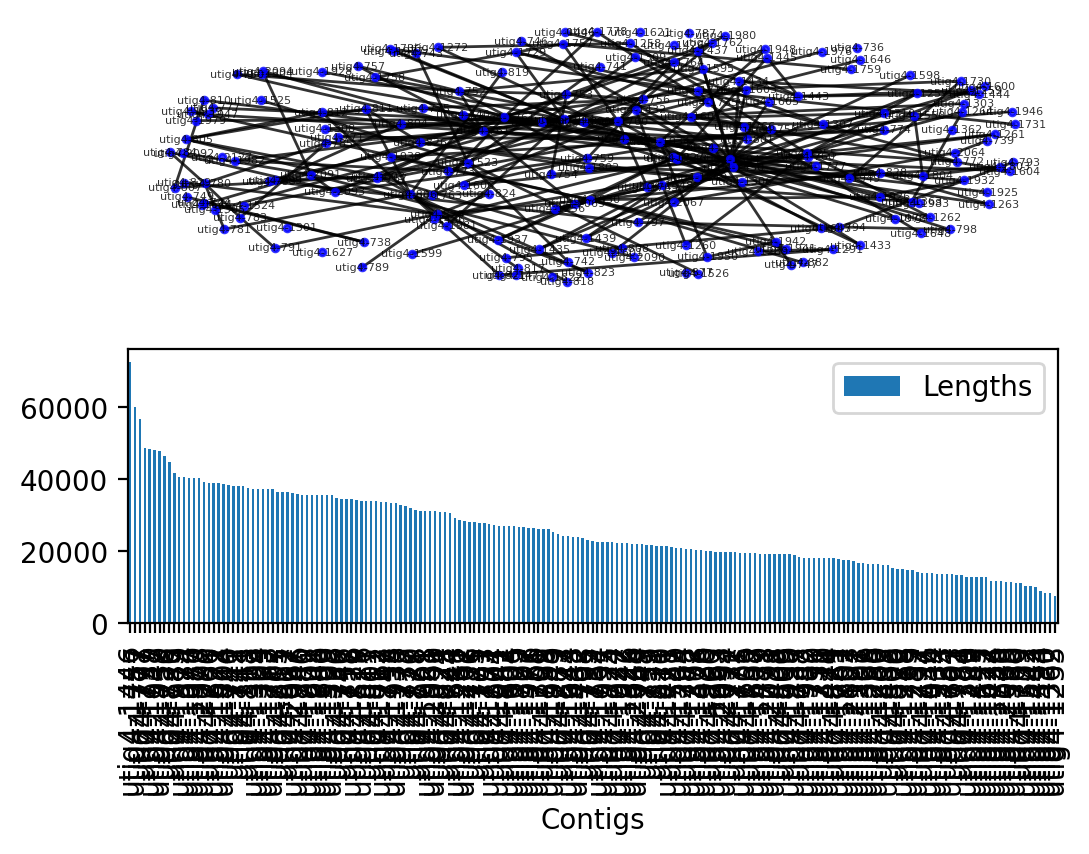

In [36]:
# Now testing this with the removal of subgraph 3, 4, 8 and 9
removal = list()
save = set([3,4, 8,9])
for i in range(len(subGNodes)):
    if i in save:
        continue
    removal.extend(subGNodes[i])
    
subGNodes, asmNodeSet2 = printSubsetBigraph(subgraphFile, subAsmSym, subAsmPre, subAsmCol, subAsmEdgeCol, worker, set(removal), True, True)

asmGraphSubsetPlot(worker, asmNodeSet2)

In [15]:
print(f'First set count: {len(asmNodeSet)}')
print(f'Second set count: {len(asmNodeSet2)}')
print(f'Intersection count: {len(asmNodeSet.intersection(asmNodeSet2))}')

First set count: 59
Second set count: 189
Intersection count: 23


#### Summary

OK, so half of the first set of assembly nodes is contained in the larger "set" of rDNA clusters. I still think that most of this might be from "hits" to repetitive regions on other clusters, but we'll see.

---
## K=5001

And the final increment.

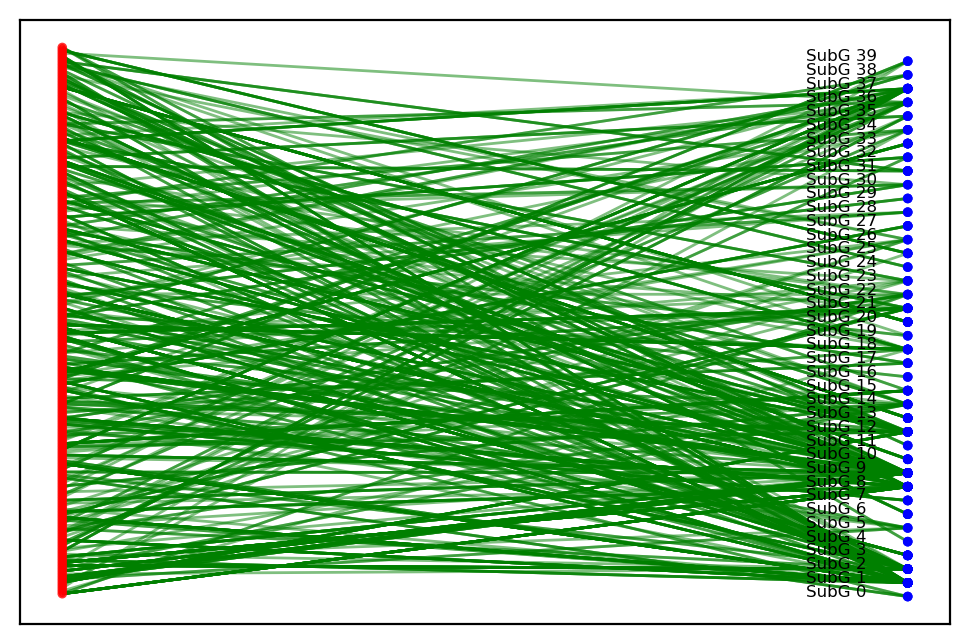

In [37]:
subgraphFile = "C:/SharedFolders/sequencing_projects/livestock_t2t/rrna_nodefilter_array/sheep_rdna_5001_500_graph.gfa"
overlayEdgeFile = "C:/SharedFolders/sequencing_projects/livestock_t2t/rrna_nodefilter_array/sheep_rdna_5001_500.allassoc.tab"

worker = setupWorker(subgraphFile, subAsmSym, subAsmPre, subAsmCol, subAsmEdgeCol, 
                assemblyGraphFile, primAsmSym, primAsmPre, primAsmCol, primAsmEdgeCol, 
                specialNodeList, specAsmCol, overlayEdgeFile, newEdgeCol)

subGNodes, asmNodeSet = printSubsetBigraph(subgraphFile, subAsmSym, subAsmPre, subAsmCol, subAsmEdgeCol, worker)

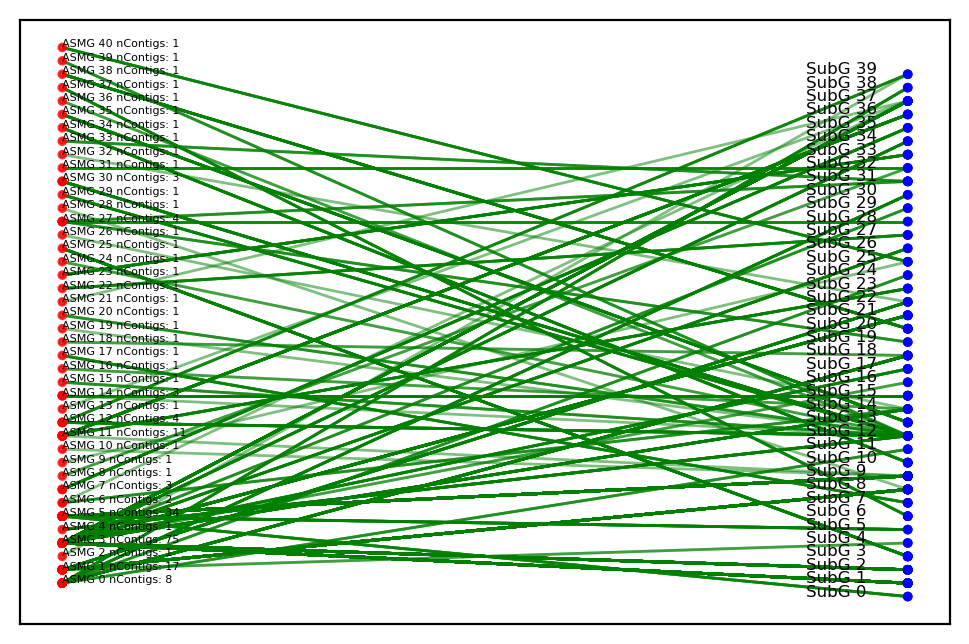

In [38]:
subGNodes, asmNodeSet = printSubsetBigraph(subgraphFile, subAsmSym, subAsmPre, subAsmCol, subAsmEdgeCol, worker, [], True, True)

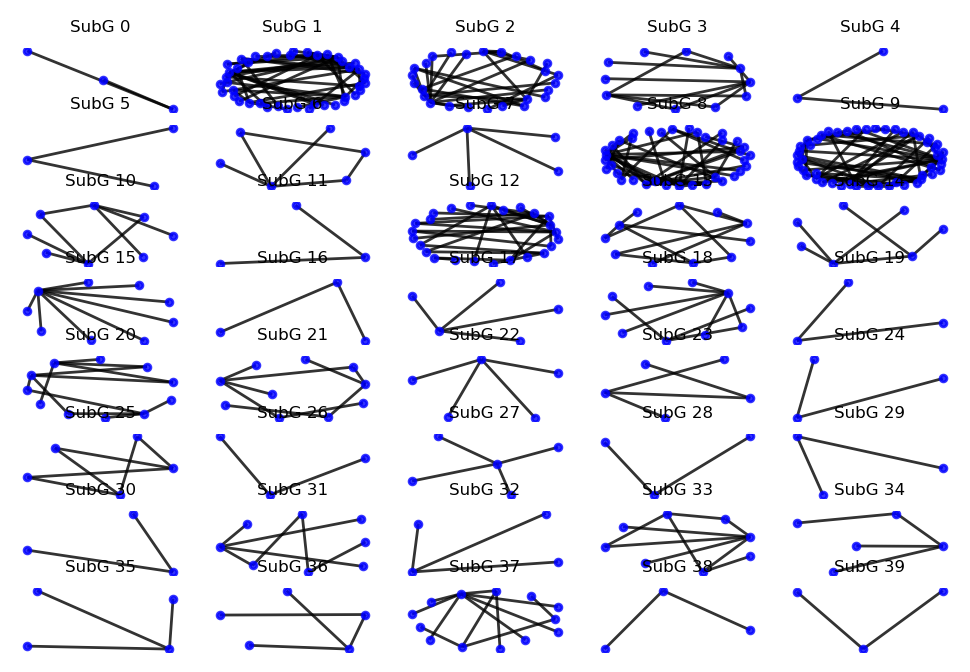

In [39]:
plotSubsetGraphs(subgraphFile, subAsmSym, subAsmPre, subAsmCol, subAsmEdgeCol, 8, 5)

1: 43
8: 36
9: 49
12: 25


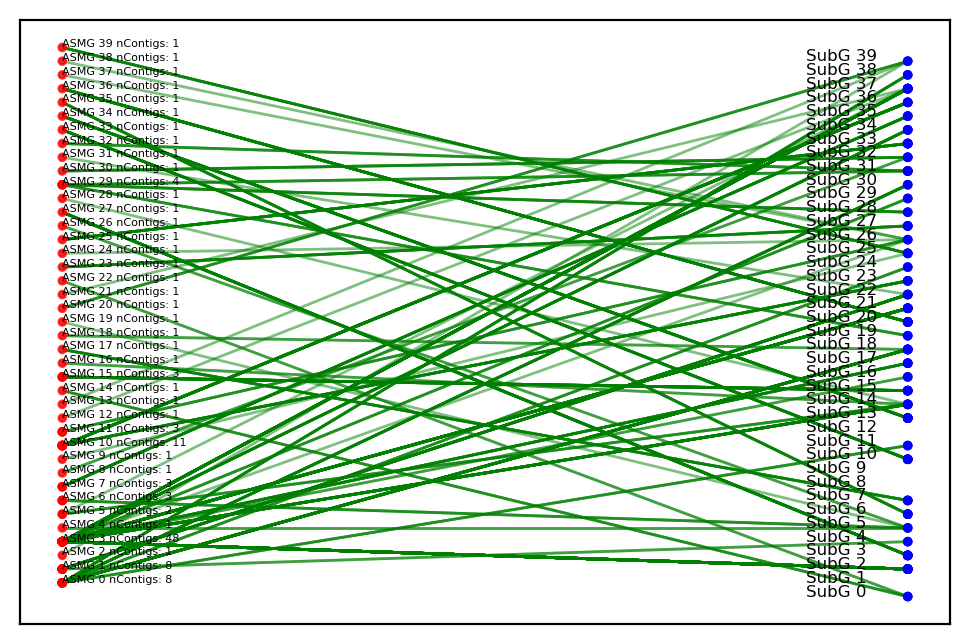

In [42]:
# Now testing this with the removal of subgraph 1, 8, 9 and 12
removal = list()
for i in [1, 8, 9, 12]:
    print(f'{i}: {len(subGNodes[i])}')
    removal.extend(subGNodes[i])
    
subGNodes, asmNodeSet = printSubsetBigraph(subgraphFile, subAsmSym, subAsmPre, subAsmCol, subAsmEdgeCol, worker, set(removal), True, True)

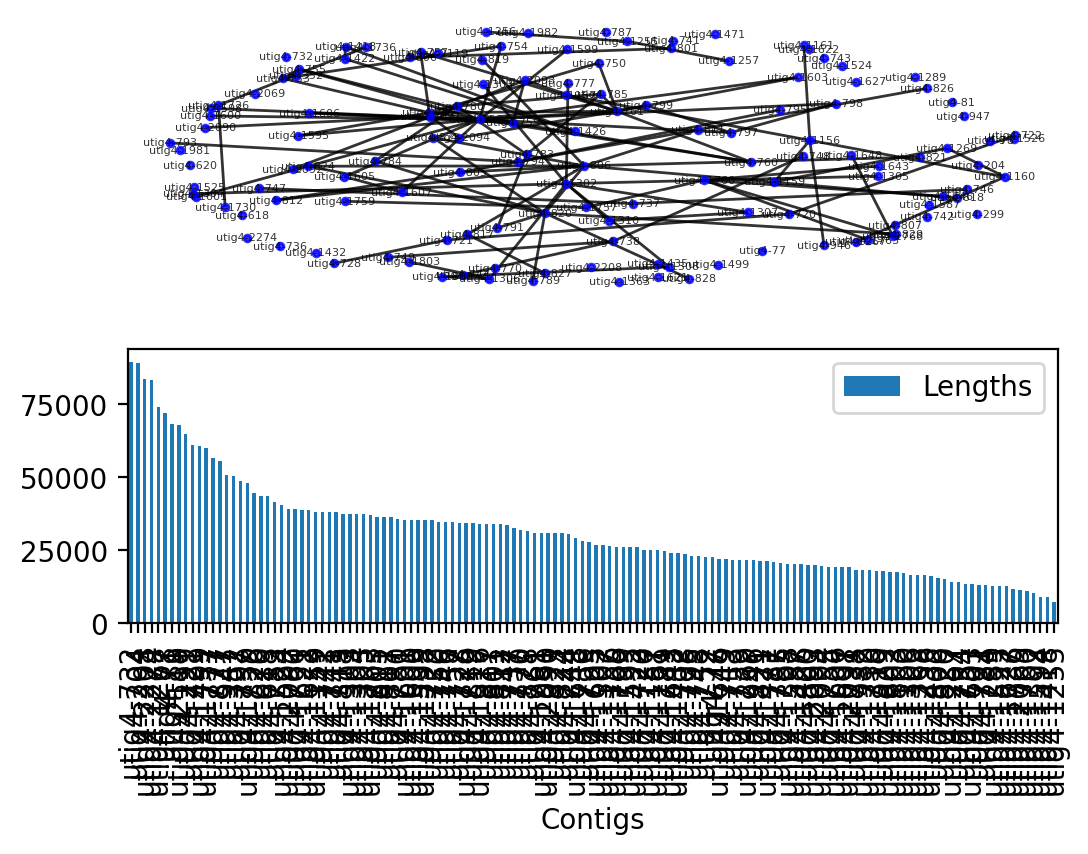

In [41]:
asmGraphSubsetPlot(worker, asmNodeSet)